# Software Vulnerability Detection using Deep Learning (Experiment Replication)

### Multicolumn experiment (All CWEs and others)

* This is from Russell et. al work (Automated Vulnerability Detection in Source Code Using Deep Representation Learning) https://arxiv.org/abs/1807.04320
* Datasets downloaded from https://osf.io/d45bw/
* Datasets distribution: Training (80%), Validation (10%), Testing (10%)
* The dataset consists of the source code of 1.27 million functions mined from open source software, labeled by static analysis for potential vulnerabilities.
* Each function's raw source code, starting from the function name, is stored as a variable-length UTF-8 string. Five binary 'vulnerability' labels are provided for each function, corresponding to the four most common CWEs in our data plus all others: 
 * CWE-120 (3.7% of functions)
 * CWE-119 (1.9% of functions)
 * CWE-469 (0.95% of functions)
 * CWE-476 (0.21% of functions)
 * CWE-other (2.7% of functions)
* Functions may have more than one detected CWE each.
* Python 3.6 and Tensorflow 2.0.0

## Pre-processing

Converting the HDF5 files for training/validation/testing datasets to python pickle for ease of future usage

In [9]:
import h5py
import pandas as pd

In [15]:
# 3 datasets available

data = h5py.File("VDISC_train.hdf5",'r')
#data = h5py.File("VDISC_validate.hdf5",'r')
#data = h5py.File("VDISC_test.hdf5",'r')

In [30]:
# List all groups
data.visit(print)

CWE-119
CWE-120
CWE-469
CWE-476
CWE-other
functionSource


Create a new dataframe from the HDF5 file

In [16]:
mydf = pd.DataFrame(list(data['functionSource']))

In [17]:
mydf['CWE-119']=list(data['CWE-119']); mydf['CWE-120']=list(data['CWE-120']); mydf['CWE-469']=list(data['CWE-469']); mydf['CWE-476']=list(data['CWE-476']); mydf['CWE-other']=list(data['CWE-other']) 

In [18]:
mydf.rename(columns={0:'functionSource'},inplace=True)

In [71]:
mydf.iloc[0:5,0:]

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True


In [19]:
mydf.to_pickle("VDISC_train.pickle")
#mydf.to_pickle("VDISC_validate.pickle")
#mydf.to_pickle("VDISC_test.pickle")

## Exploratory Data Analysis

### Importing processed datasets

In [66]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

In [4]:
### CONTINUE LATER

## Learning Phase

### Importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import pickle

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensorlfow version:  2.0.0
Eager mode:  True
GPU is available


### Setting static and global variables

In [2]:
# Generate random seed
#myrand=np.random.randint(1, 99999 + 1)
myrand=71926
np.random.seed(myrand)
tf.random.set_seed(myrand)
print("Random seed is:",myrand)

Random seed is: 71926


In [3]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10

### Importing processed datasets

In [4]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

for dataset in [train,validate,test]:
    for col in range(1,6):
        dataset.iloc[:,col] = dataset.iloc[:,col].map({False: 0, True: 1})

# Create source code sdata for tokenization
x_all = train['functionSource']
#x_all = x_all.append(validate['functionSource'])
#x_all = x_all.append(test['functionSource'])

In [5]:
# Overview of the datasets
train.head()

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True


### Tokenizing the source codes

In [5]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(x_all))
del(x_all)
print('Number of tokens: ',len(tokenizer.word_counts))

Number of tokens:  1094129


In [6]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [8]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('if', 3908040),
 ('0', 2633095),
 ('return', 2182544),
 ('i', 1720280),
 ('1', 1483872),
 ('int', 1271988),
 ('null', 1222633),
 ('the', 990541),
 ('t', 917046),
 ('n', 892342)]

### Create sequence files from the tokens

In [7]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(train['functionSource'])
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [8]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(test['functionSource'])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [9]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences(validate['functionSource'])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

In [65]:
# Example data
test.iloc[0:5,1:6]

,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False


### One-Hot-Enconding (OHE) on the datasets

In [10]:
y_train=[]
y_test=[]
y_validate=[]

for col in range(1,6):
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_validate.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))

In [14]:
# Example data
y_test[0][1:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

### Model Definition (CNN with Gaussian Noise and 5 Output Splits)

In [11]:
# Create a random weights matrix

random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [22]:
# Must use non-sequential model building to create branches in the output layer
inp_layer = tf.keras.layers.Input(shape=(INPUT_SIZE,))
mid_layers = tf.keras.layers.Embedding(input_dim = WORDS_SIZE,
                                    output_dim = 13,
                                    weights=[random_weights],
                                    input_length = INPUT_SIZE)(inp_layer)
mid_layers = tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu')(mid_layers)
mid_layers = tf.keras.layers.MaxPool1D(pool_size=5)(mid_layers)
mid_layers = tf.keras.layers.Dropout(0.5)(mid_layers)
mid_layers = tf.keras.layers.Flatten()(mid_layers)
mid_layers = tf.keras.layers.Dense(64, activation='relu')(mid_layers)
mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
output1 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output2 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output3 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output4 =tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output5 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
model = tf.keras.Model(inp_layer,[output1,output2,output3,output4,output5])

# Define custom optimizers
adam = tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print("CNN model built: ")
model.summary()

CNN model built: 
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 500, 13)      130000      input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 500, 512)     60416       embedding_5[0][0]                
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 100, 512)     0           conv1d_5[0][0]                   
__________________________________________________________________________

### Tensorboard Callbacks

In [23]:
## Create TensorBoard callbacks

callbackdir= 'D:\\temp\\cb'

tbCallback = tf.keras.callbacks.TensorBoard(log_dir=callbackdir, 
                         histogram_freq=1,
                         embeddings_freq=1,
                         write_graph=True, 
                         write_images=True)

tbCallback.set_model(model)
mld = 'model/model-ALL-{epoch:02d}.hdf5'

## Create best model callback
mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld, 
                                         monitor="val_loss",
                                         save_best_only=True, 
                                         mode='auto', 
                                         save_freq='epoch', 
                                         verbose=1)

### Model Training

In [24]:
class_weights = [{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.}]

history = model.fit(x = x_train,
          y = [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
          validation_data = (x_validate, [y_validate[0], y_validate[1], y_validate[2], y_validate[3], y_validate[4]]),
          epochs = 40,
          batch_size = 128,
          verbose =2,
          class_weight= class_weights,
          callbacks=[mcp,tbCallback])

with open('history/History-ALL-40EP-CNN', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 1019471 samples, validate on 127476 samples
Epoch 1/40

Epoch 00001: val_loss improved from inf to 1.22285, saving model to model/model-ALL-01.hdf5
1019471/1019471 - 207s - loss: 1.4301 - dense_17_loss: 0.2974 - dense_18_loss: 0.4755 - dense_19_loss: 0.0630 - dense_20_loss: 0.1981 - dense_21_loss: 0.3960 - dense_17_accuracy: 0.9801 - dense_18_accuracy: 0.9608 - dense_19_accuracy: 0.9977 - dense_20_accuracy: 0.9902 - dense_21_accuracy: 0.9716 - val_loss: 1.2229 - val_dense_17_loss: 0.2347 - val_dense_18_loss: 0.4010 - val_dense_19_loss: 0.0445 - val_dense_20_loss: 0.1886 - val_dense_21_loss: 0.3541 - val_dense_17_accuracy: 0.9751 - val_dense_18_accuracy: 0.9465 - val_dense_19_accuracy: 0.9980 - val_dense_20_accuracy: 0.9905 - val_dense_21_accuracy: 0.9673
Epoch 2/40

Epoch 00002: val_loss improved from 1.22285 to 1.13063, saving model to model/model-ALL-02.hdf5
1019471/1019471 - 203s - loss: 1.1590 - dense_17_loss: 0.2164 - dense_18_loss: 0.3676 - dense_19_loss: 0.0443 - dense_

### Model Evaluation using Testing Set

In [25]:
# Load model
model = tf.keras.models.load_model("model/model-ALL-31.hdf5")

In [128]:
results = model.evaluate(x_test, y_test, batch_size=128)
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



loss: 0.6153901273691805
dense_2_loss: 0.13200821
dense_3_loss: 0.19983554
dense_4_loss: 0.032241087
dense_5_loss: 0.08332161
dense_6_loss: 0.1679906
dense_2_accuracy: 0.9807564
dense_3_accuracy: 0.96161485
dense_4_accuracy: 0.99781823
dense_5_accuracy: 0.99064505
dense_6_accuracy: 0.97261006


### Check The Evaluation Metrics

In [28]:
predicted = model.predict(x_test)

In [ ]:
pred_test = [[],[],[],[],[]]

for col in range(0,len(predicted)):
    for row in predicted[col]:
        if row[0] >= row[1]:
            pred_test[col].append(0)
        else:
            pred_test[col].append(1)
            
for col in range(0,len(predicted)):
    print(pd.value_counts(pred_test[col]))

### Evaluate on the testing set

In [97]:

for col in range(1,6):
    print('\nThis is evaluation for column',col)
    confusion = sklearn.metrics.confusion_matrix(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])
    print(confusion)
    tn, fp, fn, tp = confusion.ravel()
    print('\nTP:',tp)
    print('FP:',fp)
    print('TN:',tn)
    print('FN:',fn)

    ## Performance measure
    print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision: '+ str(sklearn.metrics.precision_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Recall: '+ str(sklearn.metrics.recall_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))


This is evaluation for column 1
[[121949   3018]
 [   779   1673]]

TP: 1673
FP: 3018
TN: 121949
FN: 779

Accuracy: 0.9702006765082131
Precision: 0.3566403751865274
Recall: 0.682300163132137
F-measure: 0.46843063138737223
Precision-Recall AUC: 0.3864869549314679
AUC: 0.9452323096821215
MCC: 0.4801512959877963

This is evaluation for column 2
[[115497   7031]
 [  1029   3862]]

TP: 3862
FP: 7031
TN: 115497
FN: 1029

Accuracy: 0.9367441276418744
Precision: 0.35453961259524464
Recall: 0.7896135759558373
F-measure: 0.48935631018753173
Precision-Recall AUC: 0.4154790926728632
AUC: 0.939386866918996
MCC: 0.5031289528185057

This is evaluation for column 3
[[127104     37]
 [   267     11]]

TP: 11
FP: 37
TN: 127104
FN: 267

Accuracy: 0.9976141705711079
Precision: 0.22916666666666666
Recall: 0.039568345323741004
F-measure: 0.06748466257668712
Precision-Recall AUC: 0.05998085827581194
AUC: 0.9390521026364034
MCC: 0.0944389755422792

This is evaluation for column 4
[[125344    883]
 [   749   

### Plot The Model's Training History

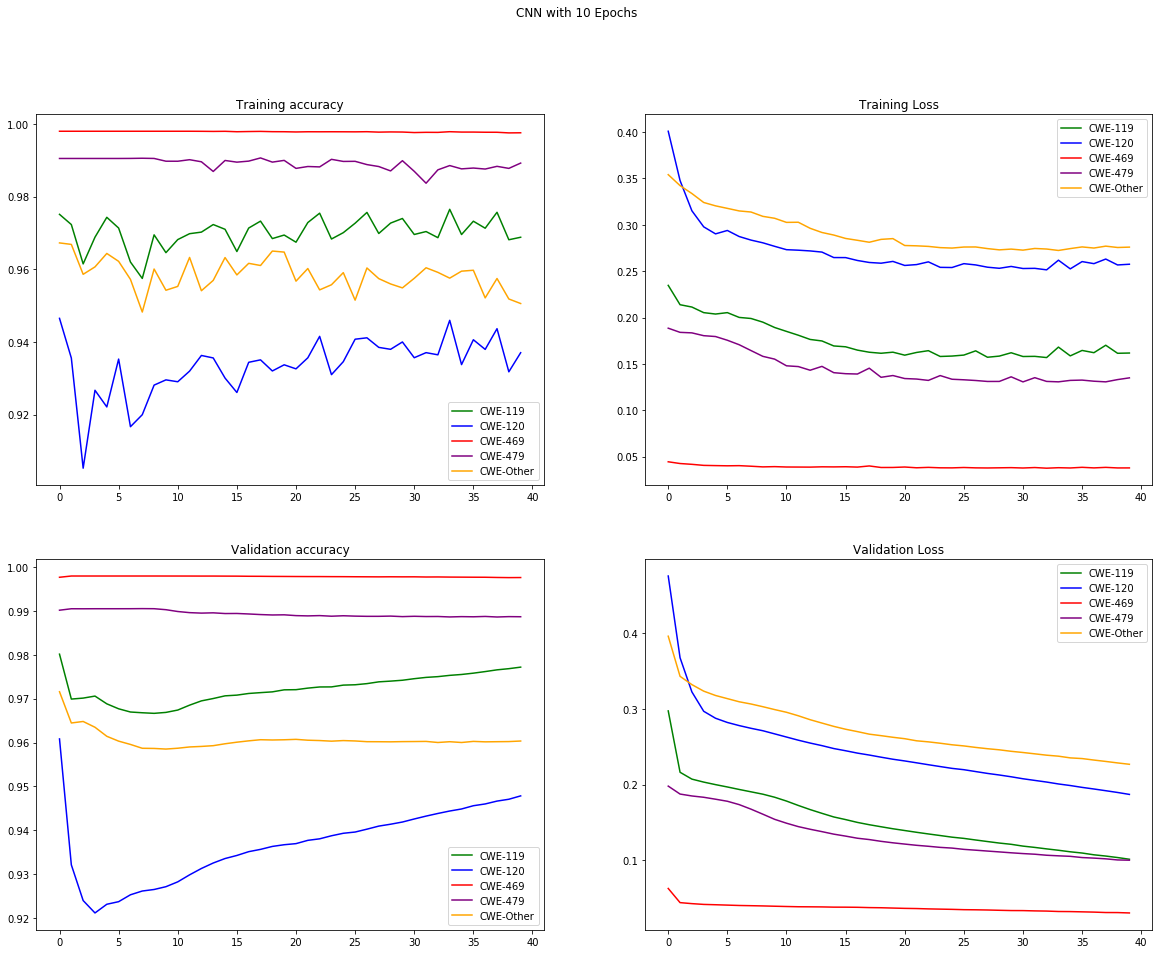

In [98]:
epochs_range = range(len(history.history[model.metrics_names[1]]))

fig, axs = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('CNN with 10 Epochs')

axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[6])], 'b', label='CWE-119', color='green')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[7])], 'b', label='CWE-120', color='blue')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[8])], 'b', label='CWE-469', color='red')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[9])], 'b', label='CWE-479', color='purple')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[10])], 'b', label='CWE-Other', color='orange')
axs[0,0].set_title('Training accuracy')
axs[0,0].legend()


axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[1])], 'b', label='CWE-119', color='green')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[2])], 'b', label='CWE-120', color='blue')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[3])], 'b', label='CWE-469', color='red')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[4])], 'b', label='CWE-479', color='purple')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[5])], 'b', label='CWE-Other', color='orange')
axs[0,1].set_title('Training Loss')
axs[0,1].legend()

axs[1,0].plot(epochs_range, history.history[model.metrics_names[6]], 'b', label='CWE-119', color='green')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[7]], 'b', label='CWE-120', color='blue')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[8]], 'b', label='CWE-469', color='red')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[9]], 'b', label='CWE-479', color='purple')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[10]], 'b', label='CWE-Other', color='orange')
axs[1,0].set_title('Validation accuracy')
axs[1,0].legend()


axs[1,1].plot(epochs_range, history.history[model.metrics_names[1]], 'b', label='CWE-119', color='green')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[2]], 'b', label='CWE-120', color='blue')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[3]], 'b', label='CWE-469', color='red')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[4]], 'b', label='CWE-479', color='purple')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[5]], 'b', label='CWE-Other', color='orange')
axs[1,1].set_title('Validation Loss')
axs[1,1].legend()

